# Clusters Model Train

对每个cluster训练一个模型

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'XGBoost'

In [2]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from xgboost import XGBRegressor

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_plus_cluster_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_plus_cluster_test_set.csv'))

In [6]:
dft_train.shape, dft_test.shape

((4371, 146), (1101, 146))

## Model Train

### DFT Model

In [7]:
fig_path = os.path.join(current_path, 'figures', 'cluster')
os.makedirs(fig_path, exist_ok=True)

In [8]:
def cluster_train(cluster, dft_train_X, dft_train_y):
    """对同一cluster进行训练"""
    xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
        colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
        objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
    # record model metrics
    model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
    # Train the model on dft data
    print("#" * 100)
    print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
    print("-" * 100)

    dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
    dft_model.train(dft_train_X, dft_train_y)

    # evaluate on the dft train set
    print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
    metrics = dft_model.evaluate(dft_train_X, dft_train_y, fig_path=os.path.join(fig_path, f'cluster{cluster}_train_error.png'), fig_show=False)
    model_metrics.loc[len(model_metrics)] = {
    'Model': MODEL_NAME,
    'Error_Type': 'Train',
    'Train_set': 'dft',
    'Test_set': 'dft',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae']
    }

    return dft_model

In [9]:
models = []
groups = dft_train.groupby('cluster')
for cluster, group in groups:
    # Split the data into features and target
    dft_train_X = group.drop(columns=['composition', 'band_gap', 'cluster'])
    dft_train_y = group['band_gap']
    # Train the model on dft data
    dft_model = cluster_train(cluster, dft_train_X, dft_train_y)
    models.append(dft_model)

####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.1s
Model training completed!
[Train_error] Evaluating DFT XGBoost on DFT train set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\cluster\cluster0_train_error.png

Model Evaluation Results:
Test set size: 663
Test set: R²: 0.9963 RMSE: 0.0420 MAE: 0.0303 MAPE: 84.9395%
####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipe

In [10]:
# test
# 查看每一cluster的测试误差
test_groups = dft_test.groupby('cluster')
for cluster, group in test_groups:
    # Split the data into features and target
    dft_test_X = group.drop(columns=['composition', 'band_gap', 'cluster'])
    dft_test_y = group['band_gap']

    # Evaluate the model on dft test set
    models[cluster].evaluate(dft_test_X, dft_test_y, fig_path=os.path.join(fig_path, f'cluster{cluster}_test_error.png'), fig_show=False)

Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\cluster\cluster0_test_error.png

Model Evaluation Results:
Test set size: 164
Test set: R²: 0.7195 RMSE: 0.3802 MAE: 0.2862 MAPE: 6693.8647%
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\cluster\cluster1_test_error.png

Model Evaluation Results:
Test set size: 263
Test set: R²: 0.7171 RMSE: 0.3843 MAE: 0.2947 MAPE: 44.0344%
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\cluster\cluster2_test_error.png

Model Evaluation Results:
Test set size: 160
Test set: R²: 0.7217 RMSE: 0.3393 MAE: 0.2550 MAPE: 193.5842%
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\cluster\cluster3_test_error.png

Model Evaluation Results:
Test set size: 514
Test set: R²: 0.4787 RMSE: 0.6266 MAE: 0.4726 MAPE: 1114.1024%


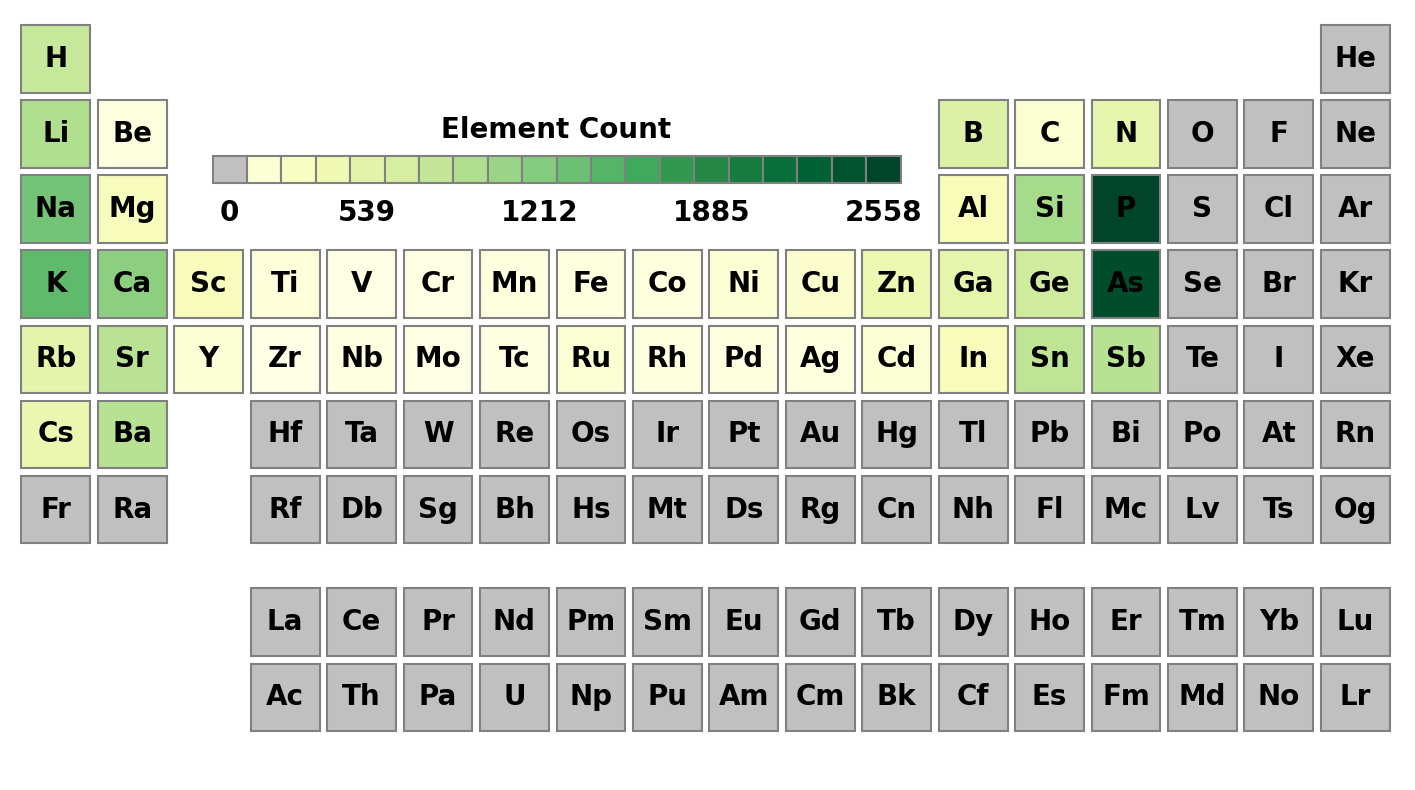

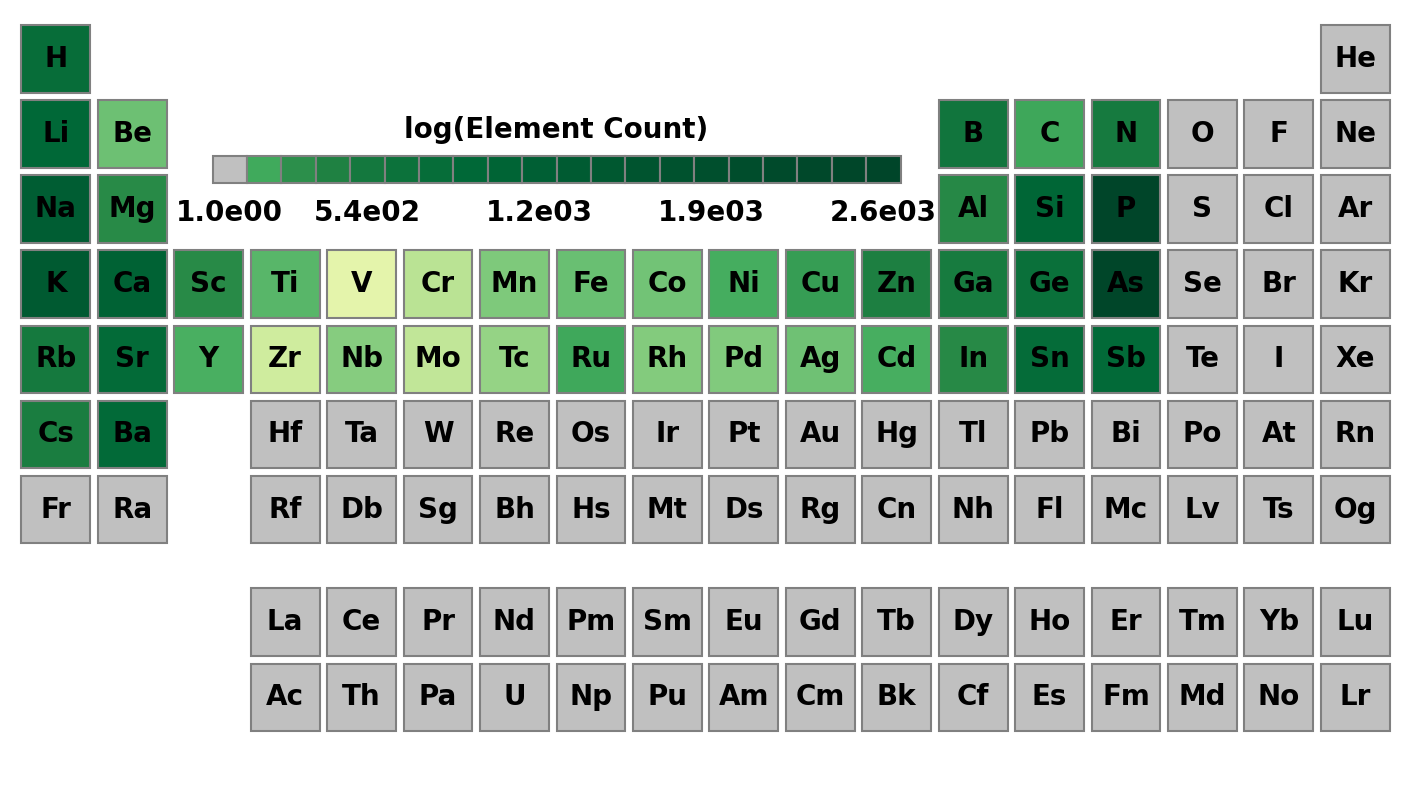

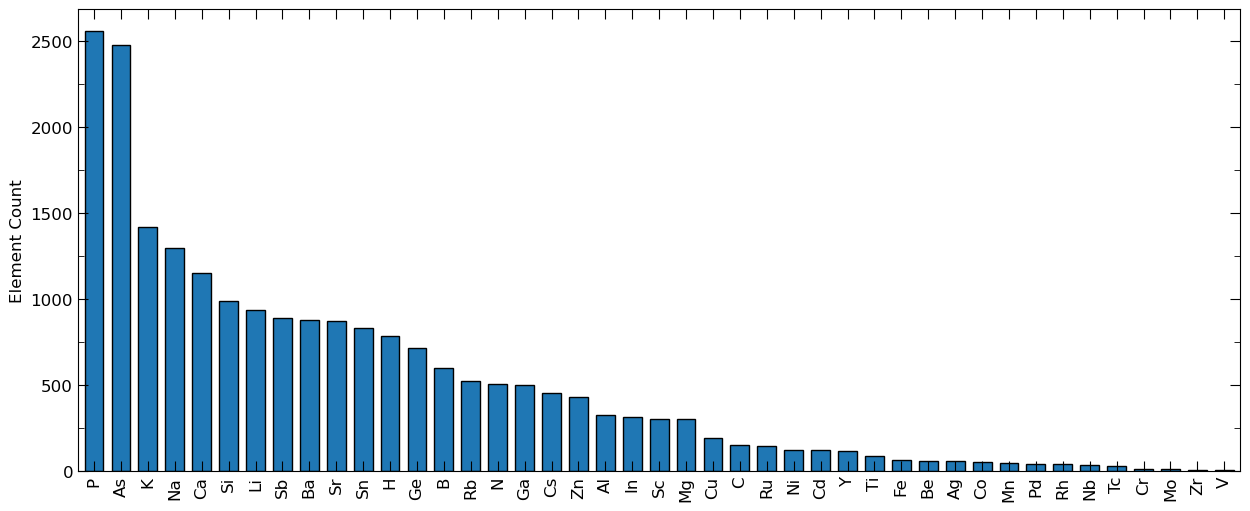

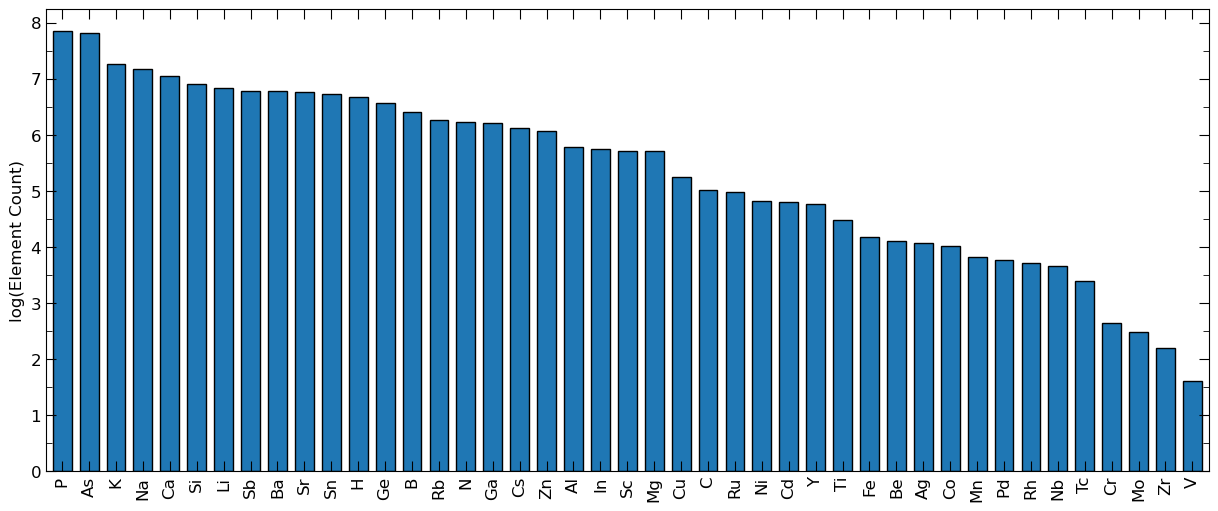

In [11]:
# cluster2拟合的最好，查看cluster2的元素分布
# Visualizing elemental prevalence in the cluster2
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = pd.concat([dft_train[dft_train['cluster'] == 2].reset_index(drop=True),
                    dft_test[dft_test['cluster'] == 2].reset_index(drop=True)], axis=0)
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df.iloc[:, 0]

save_dir = os.path.join(fig_path, 'cluster2_element_prevalence')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

- 不含卤族元素和稀有气元素的化合物拟合较好

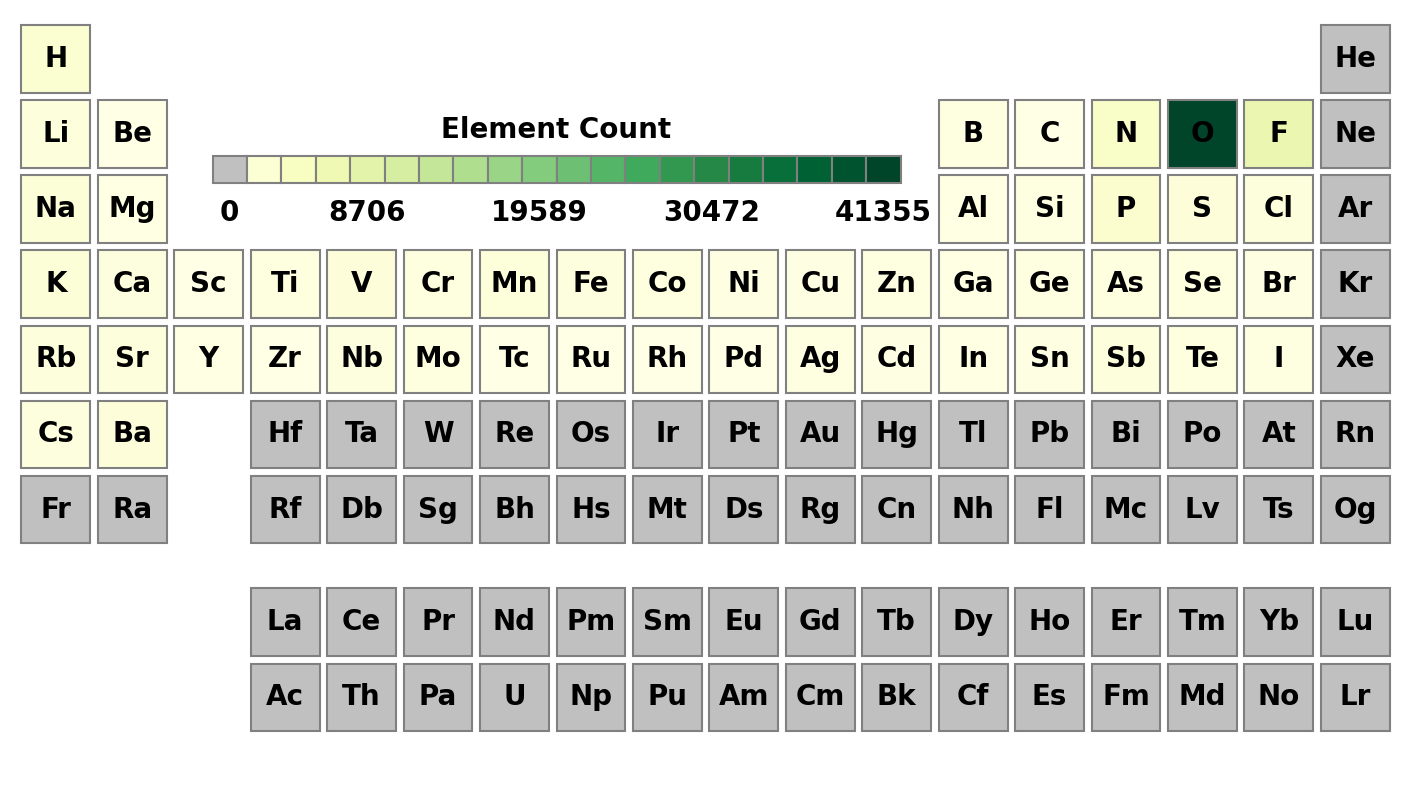

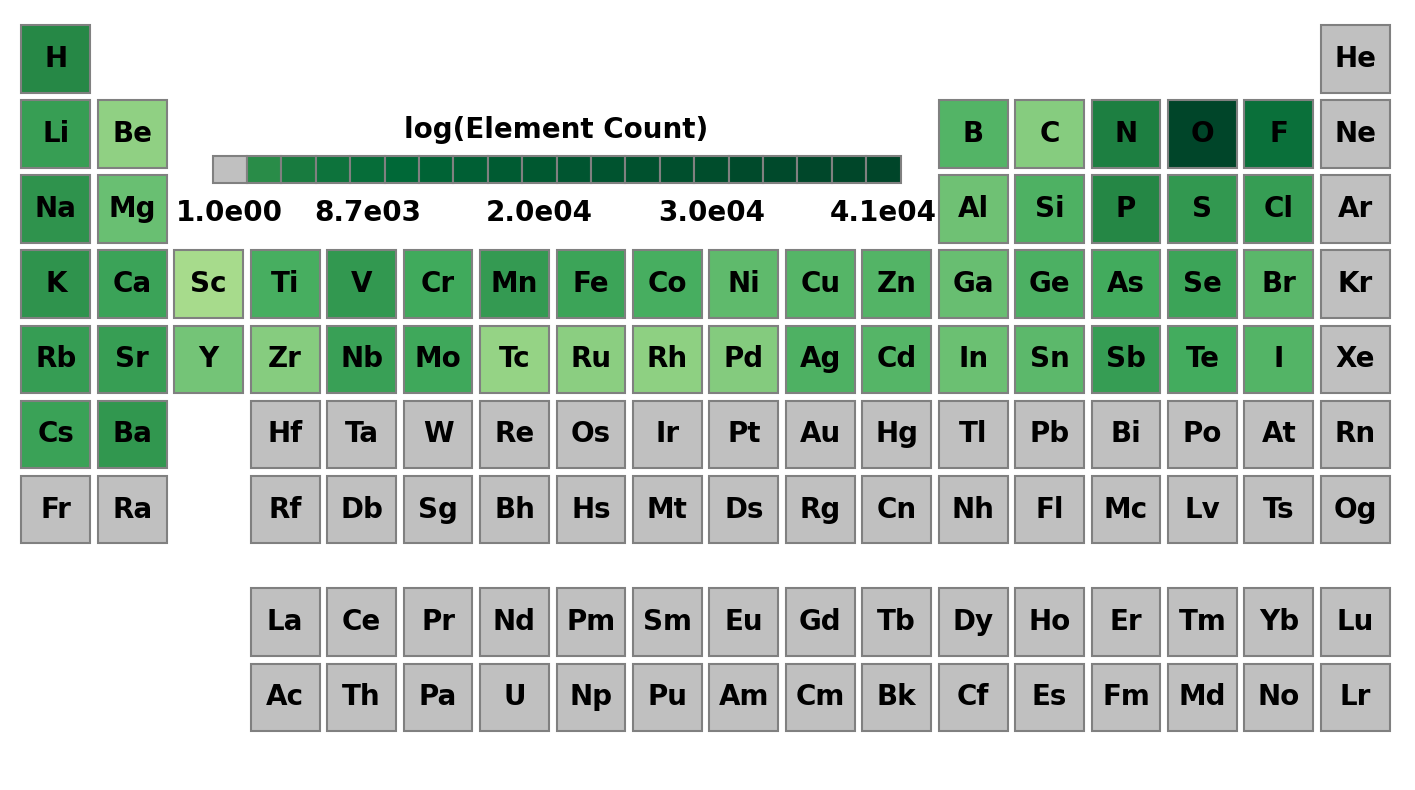

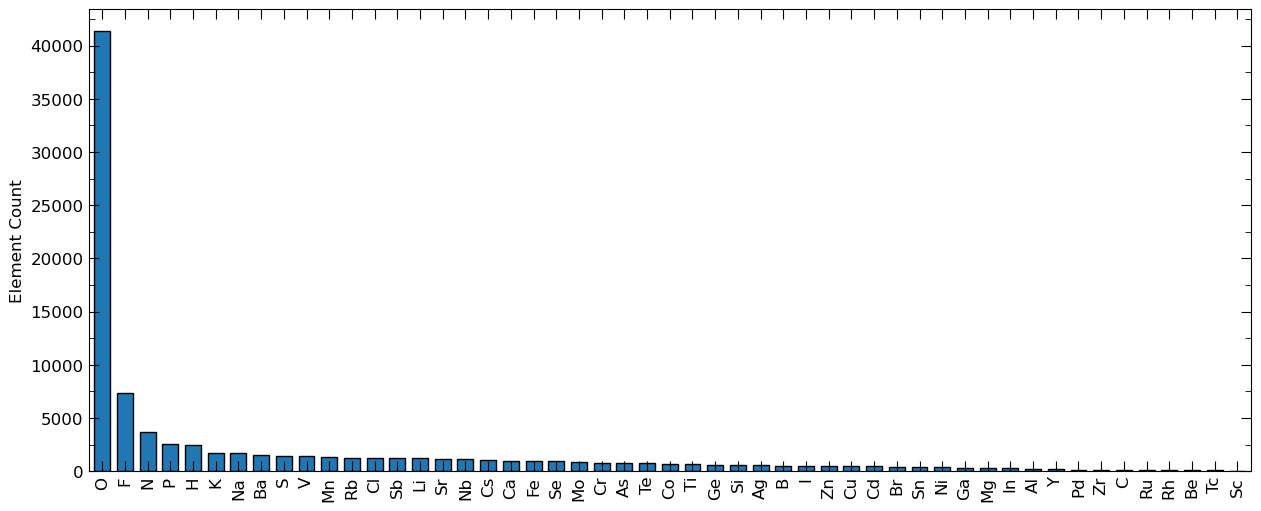

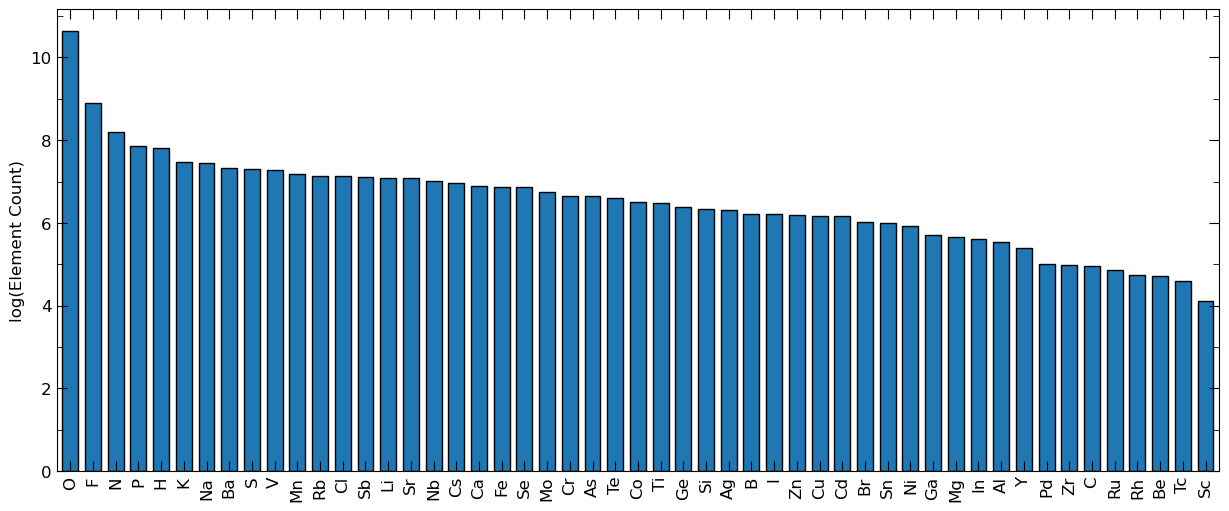

In [12]:
# cluster3拟合的最差，查看cluster3的元素分布
# Visualizing elemental prevalence in the cluster3
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = pd.concat([dft_train[dft_train['cluster'] == 3].reset_index(drop=True),
                    dft_test[dft_test['cluster'] == 3].reset_index(drop=True)], axis=0)
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df.iloc[:, 0]

save_dir = os.path.join(fig_path, 'cluster3_element_prevalence')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

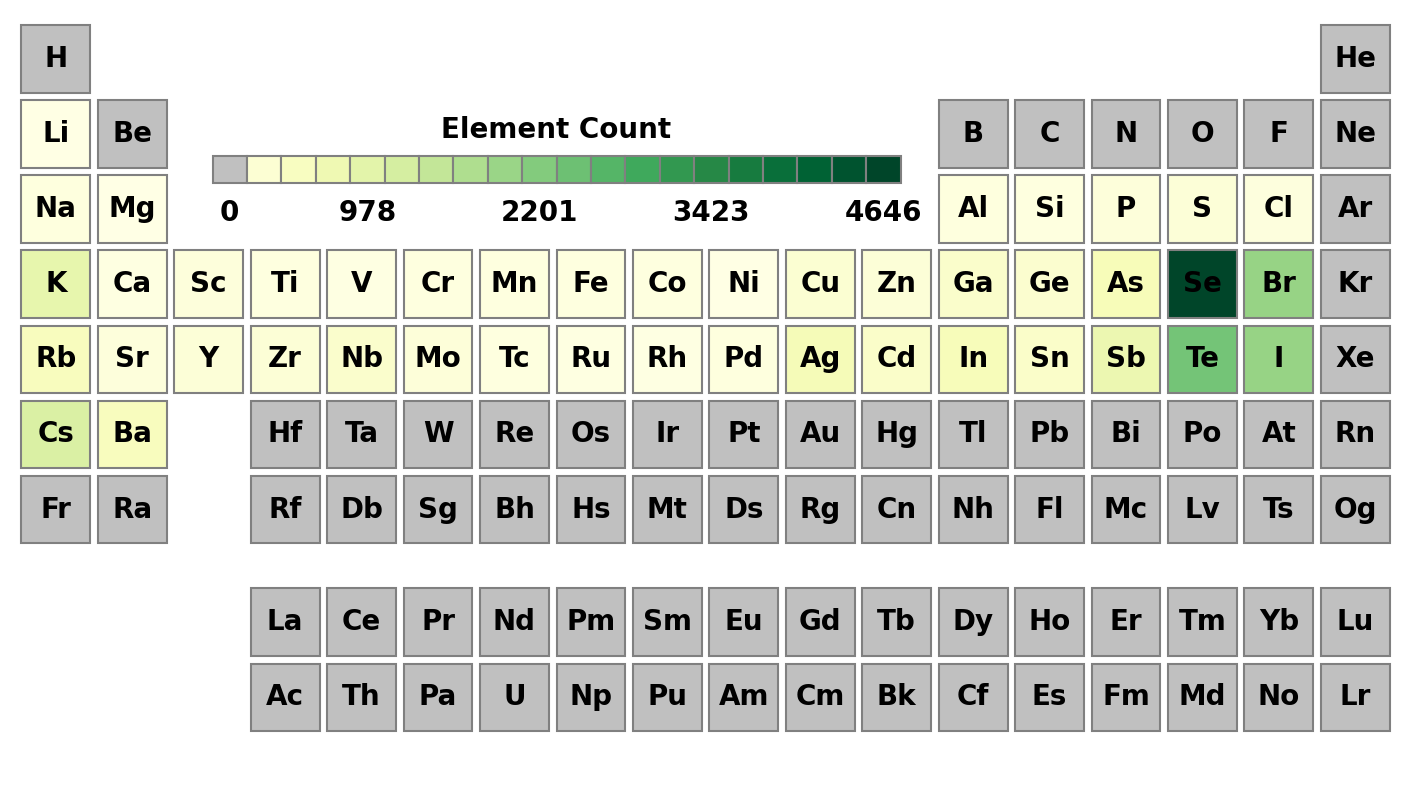

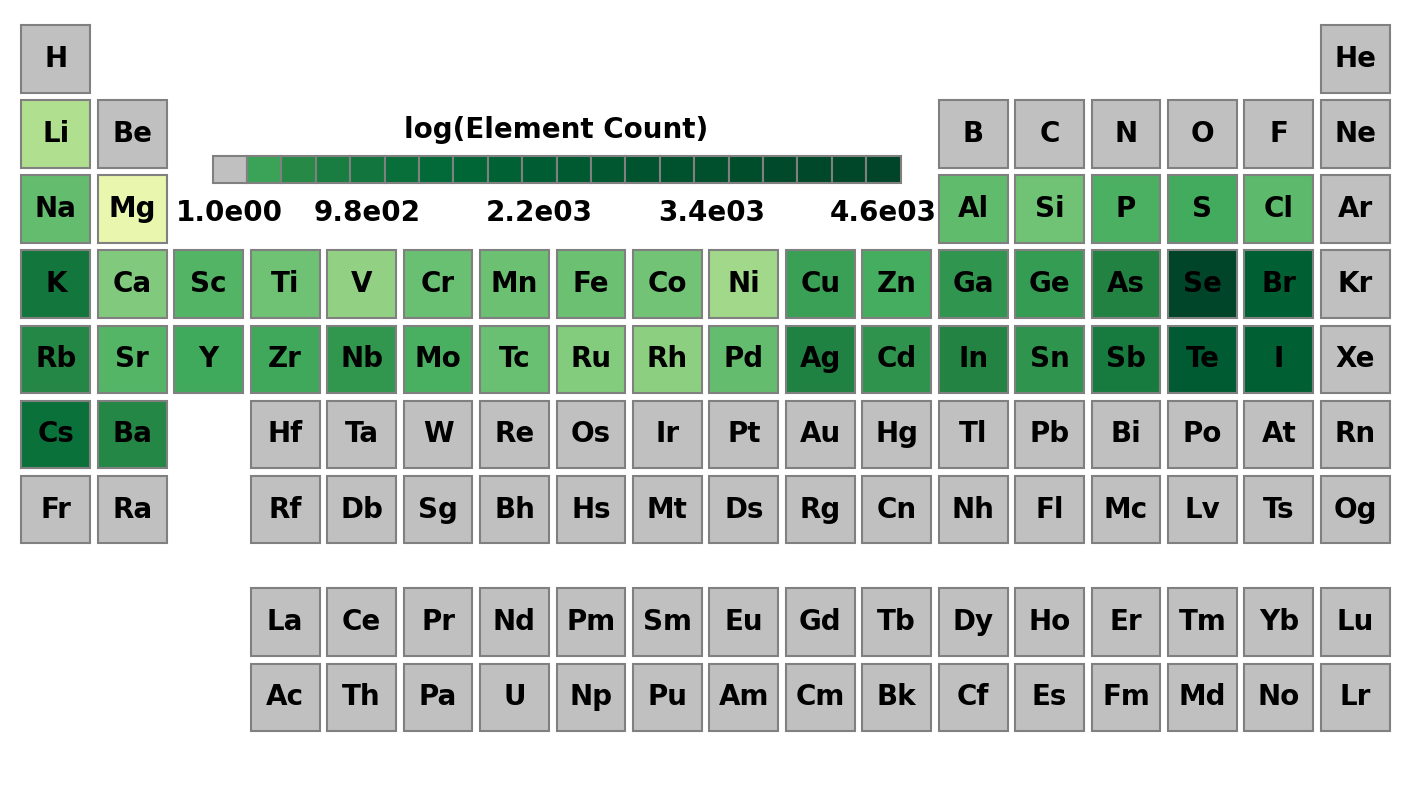

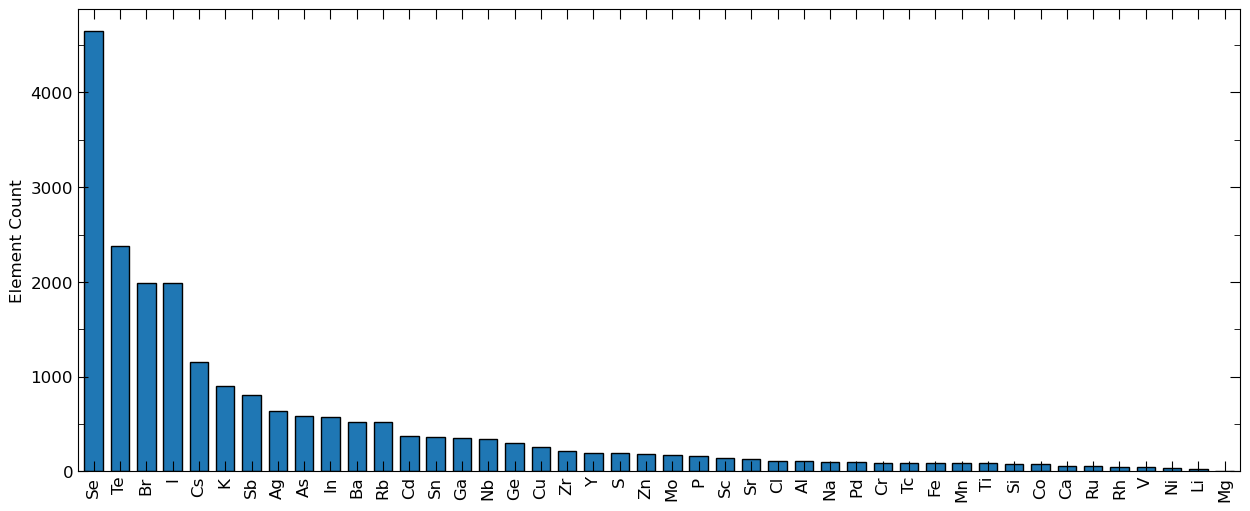

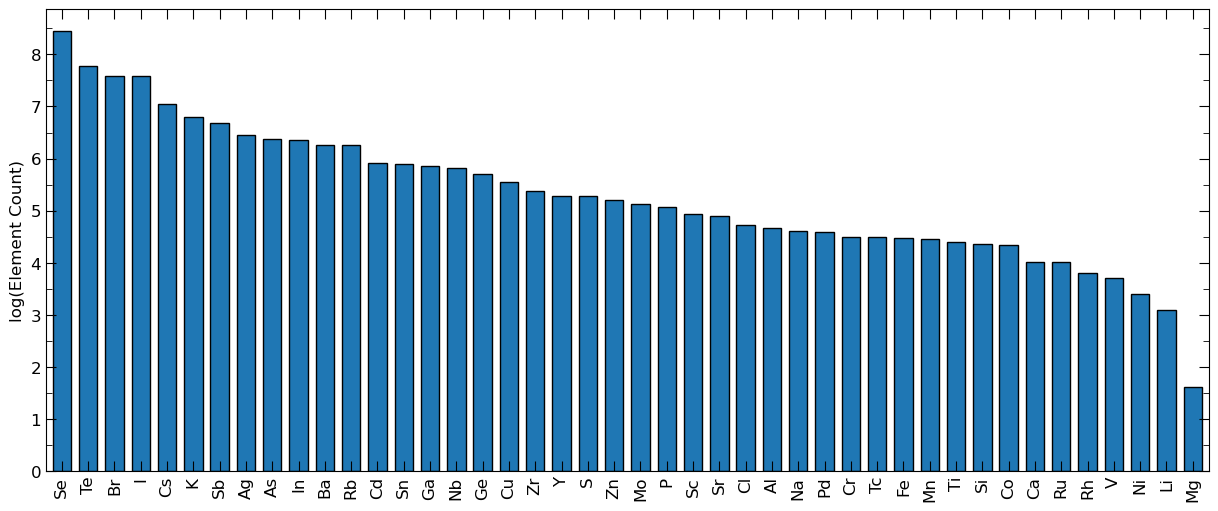

In [13]:
# 查看cluster0的元素分布
# Visualizing elemental prevalence in the cluster0
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = pd.concat([dft_train[dft_train['cluster'] == 0].reset_index(drop=True),
                    dft_test[dft_test['cluster'] == 0].reset_index(drop=True)], axis=0)
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df.iloc[:, 0]

save_dir = os.path.join(fig_path, 'cluster0_element_prevalence')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

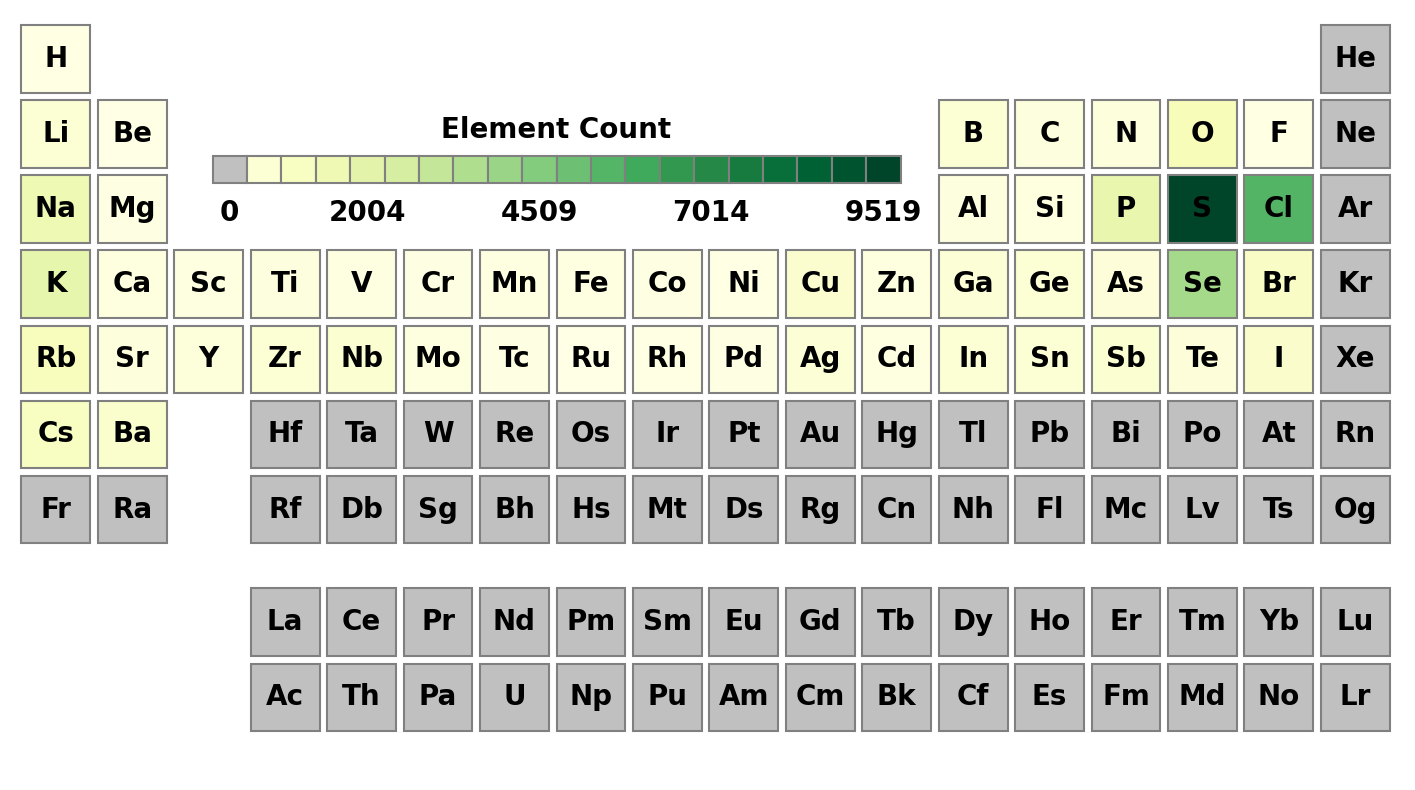

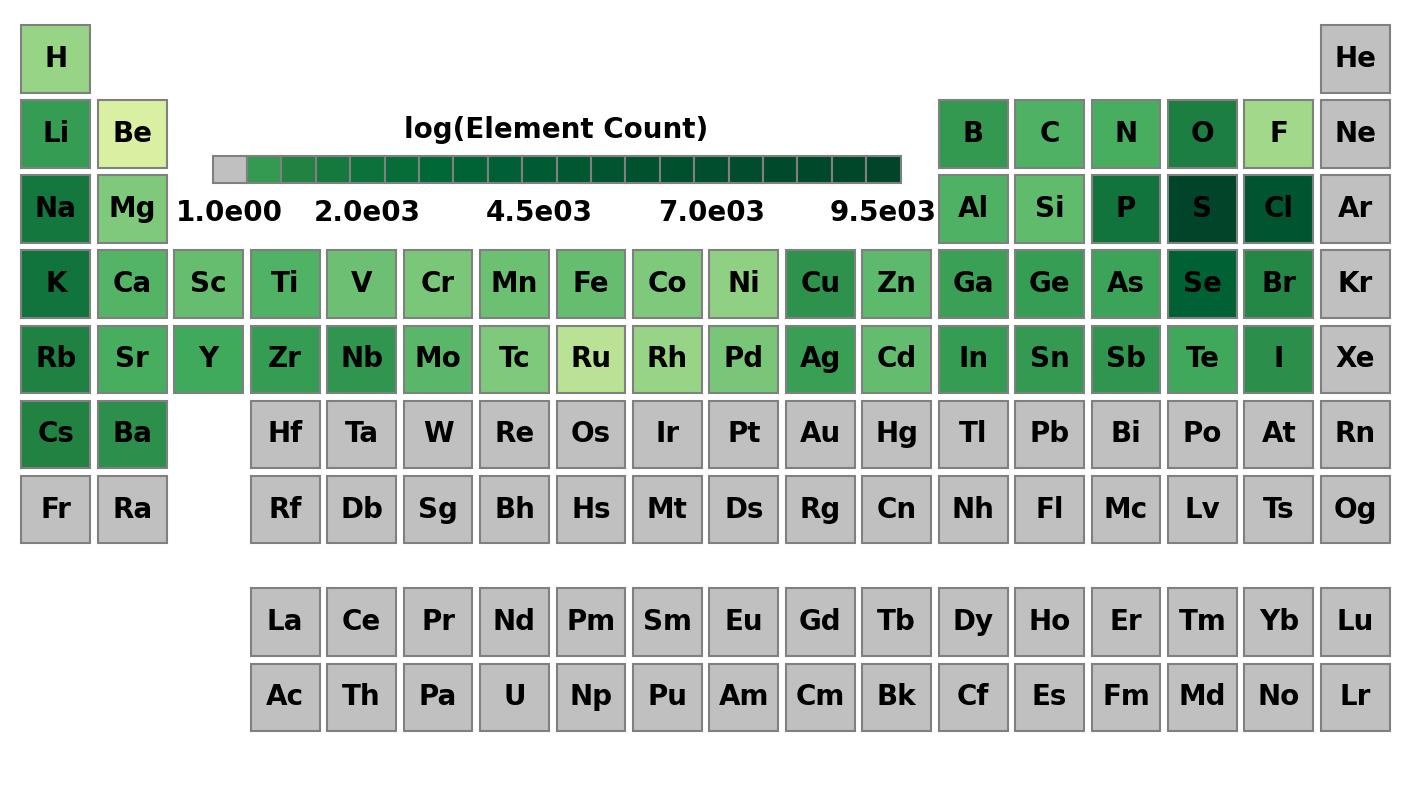

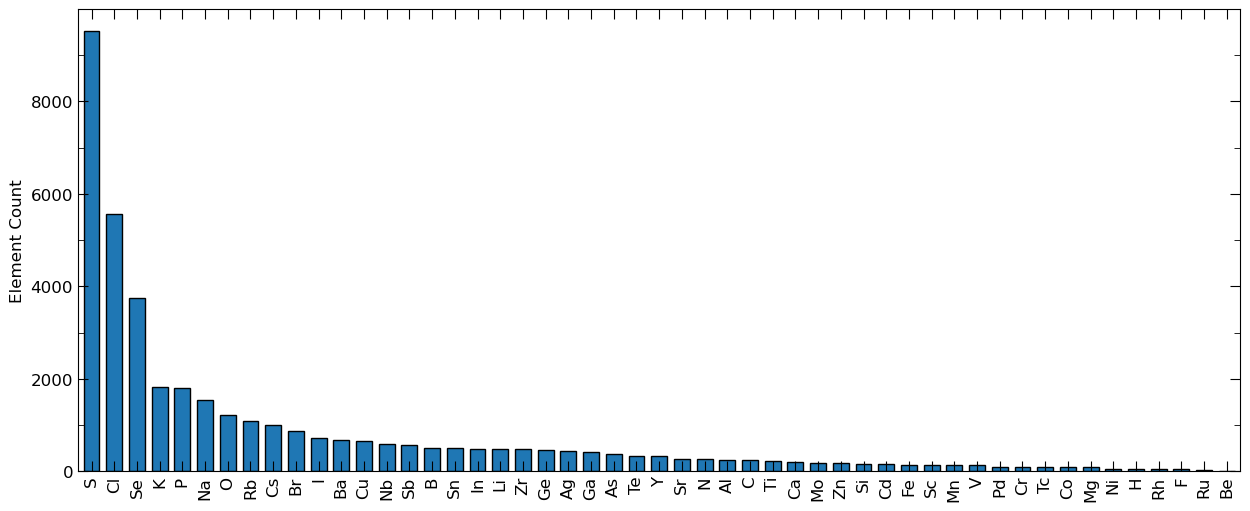

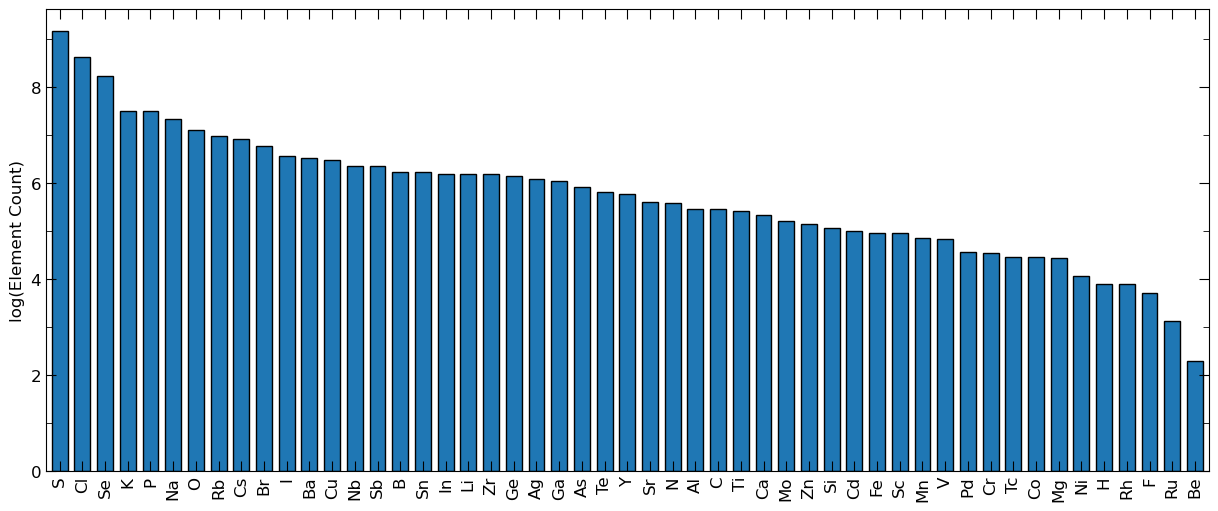

In [14]:
# 查看cluster1的元素分布
# Visualizing elemental prevalence in the cluster1
from Utools.ML_figures.figures import element_prevalence
import matplotlib.pyplot as plt

data_df = pd.concat([dft_train[dft_train['cluster'] == 1].reset_index(drop=True),
                    dft_test[dft_test['cluster'] == 1].reset_index(drop=True)], axis=0)
current_dir = os.getcwd()
os.chdir('./Utools')  # Change to where ML_figures is a direct subdirectory

formula = data_df.iloc[:, 0]

save_dir = os.path.join(fig_path, 'cluster1_element_prevalence')
os.makedirs(save_dir, exist_ok=True)
element_prevalence(formula,
                   name='element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence_ptable',
                   save_dir=save_dir,
                   log_scale=True)

plt.rcParams.update({'font.size': 12})
element_prevalence(formula,
                   name='element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=False)
element_prevalence(formula,
                   name='log_element_prevalence',
                   save_dir=save_dir,
                   ptable_fig=False,
                   log_scale=True)

os.chdir(current_dir)  # Return to previous directory

In [15]:
# 查看整个数据集的误差
y_pred = []
# 对于dft_test中的每一个数据
for i in range(len(dft_test)):
    # 获取当前数据的cluster
    cluster = dft_test['cluster'][i]
    # 获取当前数据的特征
    test_X = dft_test.drop(columns=['composition', 'band_gap', 'cluster']).iloc[i, :].to_frame().T
    # 预测
    y_pred.append(models[cluster].predict(test_X))

In [16]:
y_test = dft_test['band_gap'].values
y_test

array([0.4736, 2.8072, 1.3274, ..., 1.3194, 1.4516, 1.5958], shape=(1101,))

In [17]:
y_pred = np.array(y_pred).reshape(-1)
y_pred

array([1.555877 , 2.0692031, 1.1139603, ..., 1.6944948, 1.8817805,
       2.2052937], shape=(1101,), dtype=float32)

Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\cluster\test_error.png


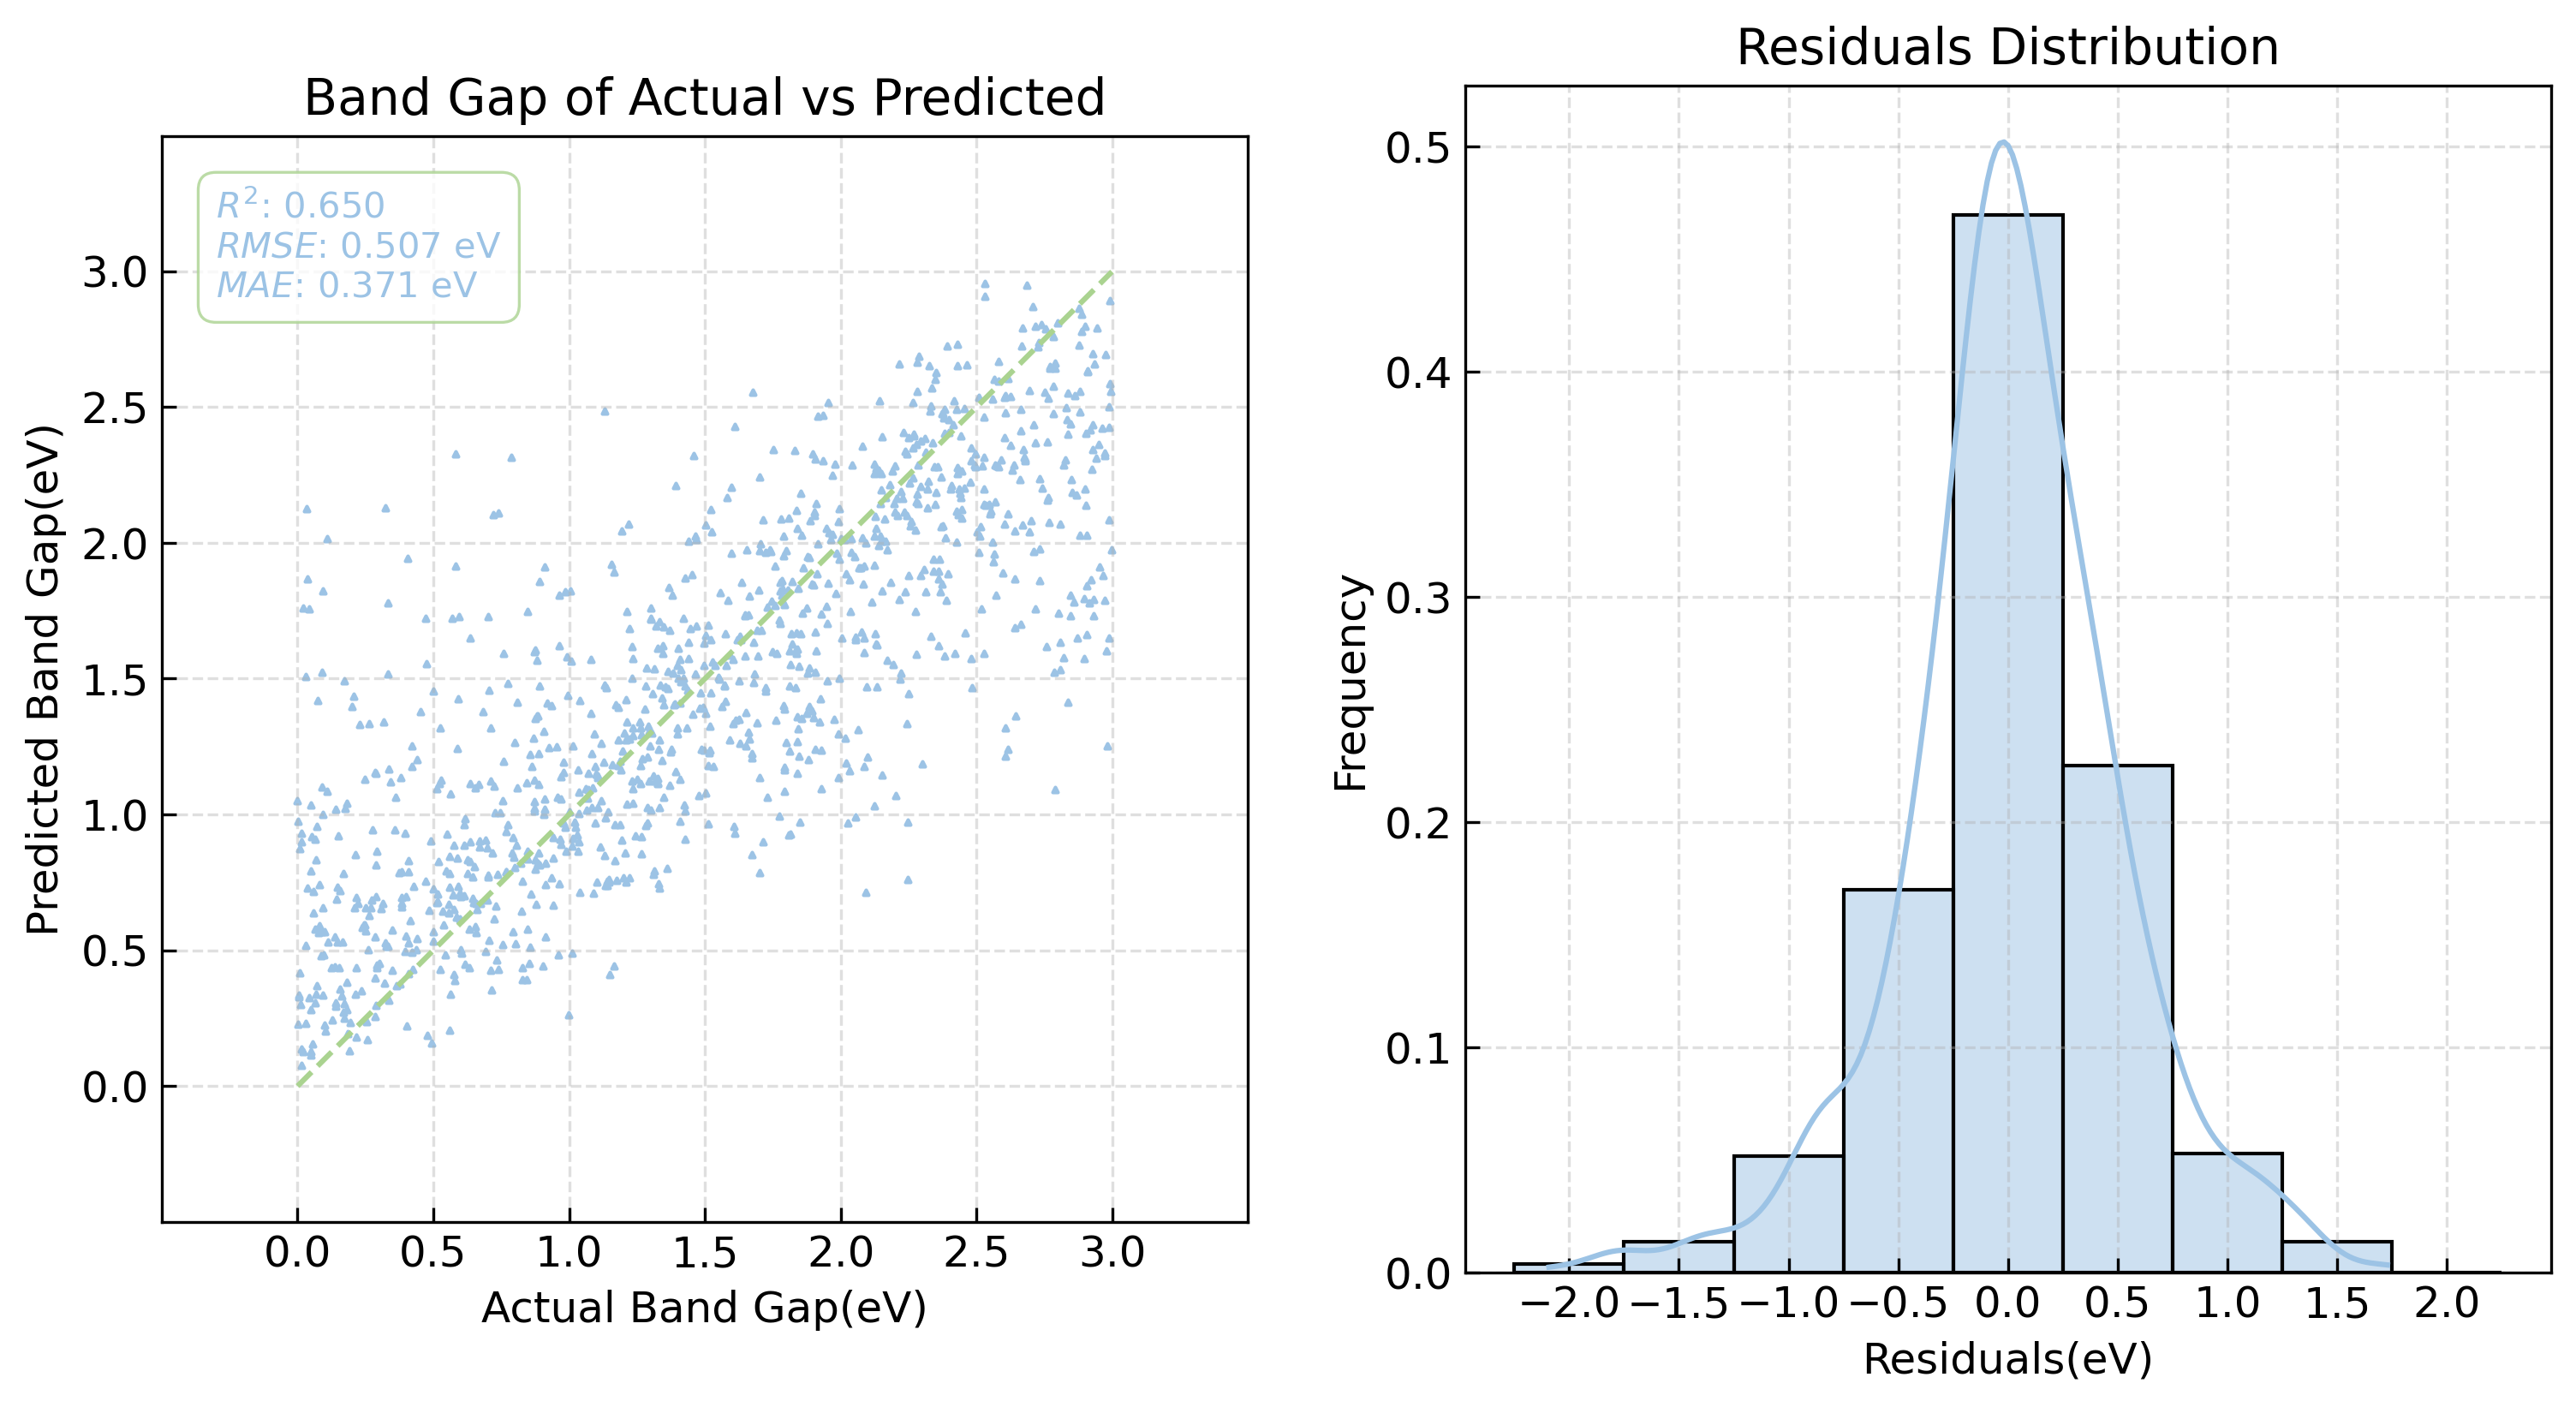

In [18]:
from Utools.draw import model_performance
test_r2, test_rmse, test_mae = model_performance(y_test, y_pred, fig_path=os.path.join(fig_path, 'test_error.png')) 